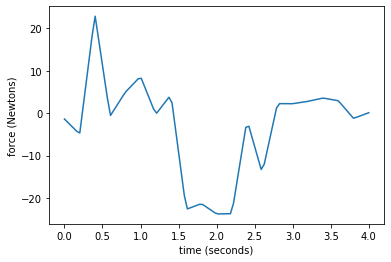

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (DirectCollocation, DiagramBuilder, PiecewisePolynomial,
                         PlanarSceneGraphVisualizer, SceneGraph, Simulator,
                         Solve, TrajectorySource)
from pydrake.examples.acrobot import AcrobotGeometry, AcrobotPlant
from underactuated import FindResource

plant = AcrobotPlant()
context = plant.CreateDefaultContext()

dircol = DirectCollocation(plant,
                           context,
                           num_time_samples=21,
                           minimum_timestep=0.2,
                           maximum_timestep=0.2)

dircol.AddEqualTimeIntervalsConstraints()

# Add input limits.
torque_limit = 25.0  # N*m.
u = dircol.input()
dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

initial_state = (0., 0., 0., 0.)
dircol.AddBoundingBoxConstraint(initial_state, initial_state,
                                dircol.initial_state())

# More elegant version is blocked on drake #8315:
# dircol.AddLinearConstraint(dircol.initial_state() == initial_state)

final_state = (math.pi, 0., 0., 0.)
dircol.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())
# dircol.AddLinearConstraint(dircol.final_state() == final_state)

#R = 10  # Cost on input "effort".
#dircol.AddRunningCost(R * u[0]**2)

# Add a final cost equal to the total duration.
dircol.AddFinalCost(dircol.time())

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    [0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(dircol)
assert (result.is_success())

u_trajectory = dircol.ReconstructInputTrajectory(result)
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_lookup = np.vectorize(u_trajectory.value)
u_values = u_lookup(times)

plt.figure()
plt.plot(times, u_values)
plt.xlabel("time (seconds)")
plt.ylabel("force (Newtons)");

<IPython.core.display.Javascript object>


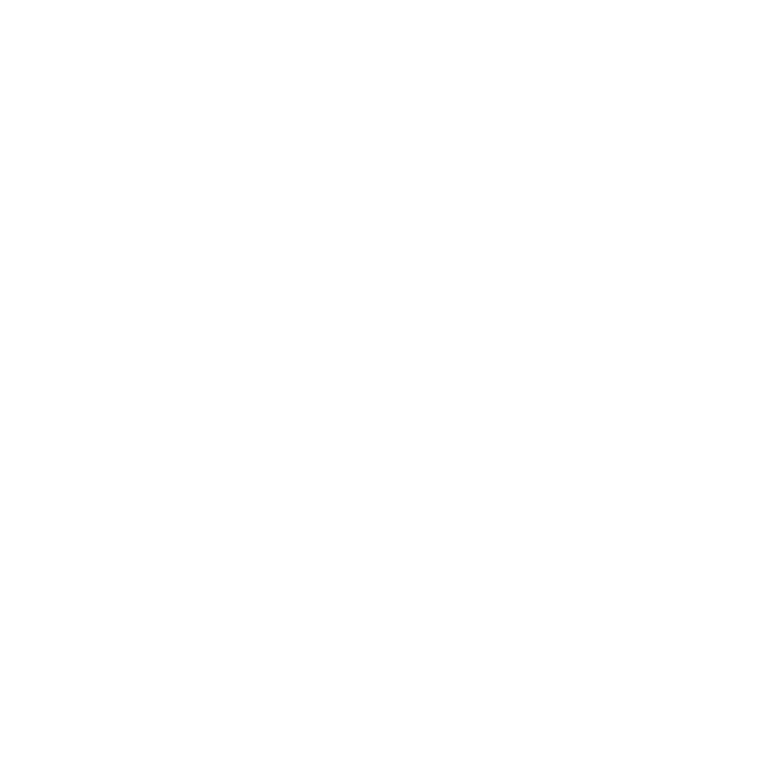

In [4]:
from IPython.display import HTML
#%matplotlib widget
from underactuated.jupyter import setup_matplotlib_backend
#plt_is_interactive = setup_matplotlib_backend()
plt_is_interactive = False


x_trajectory = dircol.ReconstructStateTrajectory(result)

builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_trajectory))
scene_graph = builder.AddSystem(SceneGraph())
AcrobotGeometry.AddToBuilder(builder, source.get_output_port(0), scene_graph)
visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-4., 4.], ylim=[-4., 4.], 
                               show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))

simulator = Simulator(builder.Build())

# Simulate and animate
if not plt_is_interactive:
    visualizer.start_recording()
simulator.AdvanceTo(x_trajectory.end_time())
if not plt_is_interactive:
    ani = visualizer.get_recording_as_animation()
    HTML(ani.to_jshtml())



In [6]:
HTML(ani.to_html5_video())